# Setup and Load Data

In [1]:
!pip install tensorflow opencv-python matplotlib

  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (787 bytes)


Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
streamlit 1.32.1 requires protobuf<5,>=3.20, but you have protobuf 3.19.6 which is incompatible.


In [12]:
pip list

Package                                  Version
---------------------------------------- ------------
absl-py                                  1.3.0
aiohttp                                  3.9.5
aiosignal                                1.3.1
alembic                                  1.13.1
altair                                   4.2.0
annotated-types                          0.6.0
anyio                                    3.6.2
appdirs                                  1.4.4
argon2-cffi                              21.3.0
argon2-cffi-bindings                     21.2.0
asgiref                                  3.8.1
astroid                                  2.11.7
asttokens                                2.0.8
astunparse                               1.6.3
async-timeout                            4.0.3
attrs                                    23.2.0
autopep8                                 1.6.0
Babel                                    2.10.3
backcall                                 0.2.

pyproject_hooks                          1.1.0
pyright                                  1.1.363
pyrsistent                               0.18.1
pysbd                                    0.3.4
PySocks                                  1.7.1
pytesseract                              0.3.10
pytest                                   8.2.0
pytest-asyncio                           0.19.0
python-dateutil                          2.8.2
python-dotenv                            1.0.0
python-multipart                         0.0.9
python-slugify                           6.1.2
pytube                                   15.0.0
pytz                                     2022.1
pytz-deprecation-shim                    0.1.0.post0
PyWavelets                               1.4.1
PyYAML                                   6.0.1
pyzmq                                    24.0.1
qtconsole                                5.5.1
QtPy                                     2.4.1
ratelimiter                              1.2.0

# Remove images

In [205]:
import tensorflow as tf
import os
import cv2
import imghdr

In [206]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [207]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load data

In [209]:
import numpy as np
from matplotlib import pyplot as plt

In [265]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 532 files belonging to 2 classes.


In [281]:
data_iter = data.as_numpy_iterator().next()

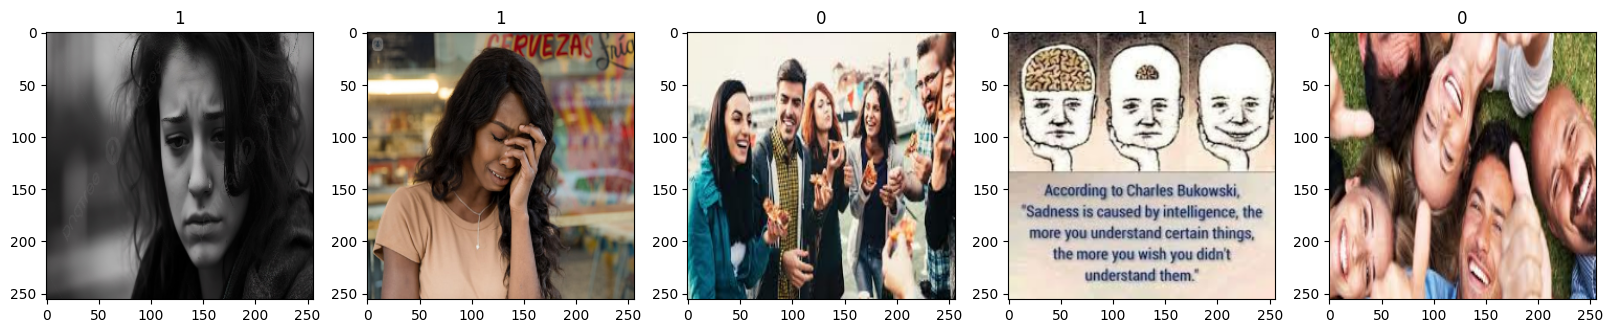

In [282]:
# Visualise loaded data
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(data_iter[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(data_iter[1][idx])

In [283]:
# 1 - Sad face
# 0 - Happy face

# Scale data

In [284]:
scaled_data = data.map(lambda x,y: (x/255, y))

In [285]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [286]:
batch = scaled_iterator.next()

In [287]:
batch[0].min(), batch[0].max()

(0.0, 1.0)

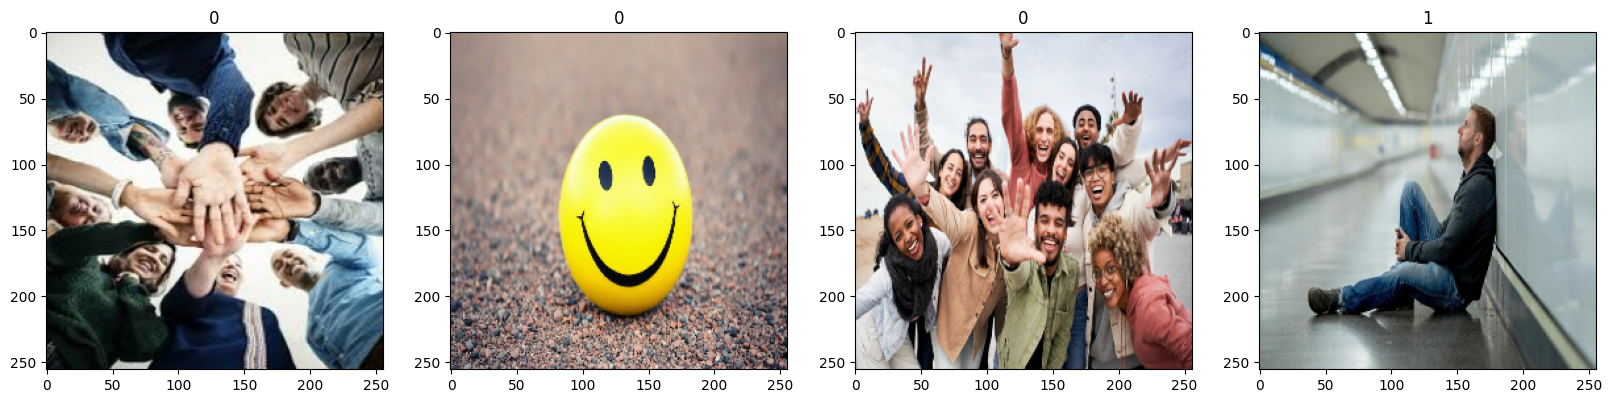

In [288]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

 # Split Data

In [289]:
len(data)

17

In [290]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+2

In [291]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Build Deep Learning Model

In [175]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [176]:
model = Sequential()

In [177]:
model.add(Conv2D(16, kernel_size=(3,3), strides=1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,kernel_size=(3,3),strides= 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,kernel_size=(3,3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


In [178]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [179]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      


# Train the model

In [180]:
logdir='logs'

In [181]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [182]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 16s 1s/step - loss: 1.1541 - accuracy: 0.6023 - val_loss: 0.6170 - val_accuracy: 0.6562
Epoch 2/20
11/11 [==============================] - 21s 2s/step - loss: 0.6391 - accuracy: 0.5938 - val_loss: 0.6090 - val_accuracy: 0.6250
Epoch 3/20
11/11 [==============================] - 19s 2s/step - loss: 0.6130 - accuracy: 0.6364 - val_loss: 0.5860 - val_accuracy: 0.6458
Epoch 4/20
11/11 [==============================] - 19s 2s/step - loss: 0.5969 - accuracy: 0.6733 - val_loss: 0.5755 - val_accuracy: 0.6979
Epoch 5/20
11/11 [==============================] - 20s 2s/step - loss: 0.5778 - accuracy: 0.7955 - val_loss: 0.5256 - val_accuracy: 0.6875
Epoch 6/20
11/11 [==============================] - 21s 2s/step - loss: 0.5346 - accuracy: 0.7500 - val_loss: 0.4848 - val_accuracy: 0.7396
Epoch 7/20
11/11 [==============================] - 20s 2s/step - loss: 0.5439 - accuracy: 0.7472 - val_loss: 0.4783 - val_accuracy: 0.7188
Epoch 8/20
11/11 [==

# Perfomance

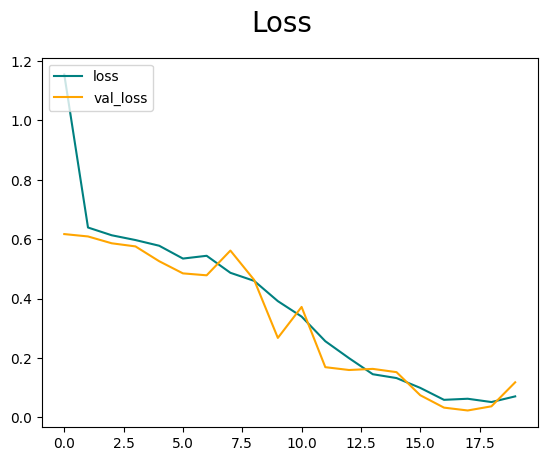

In [183]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

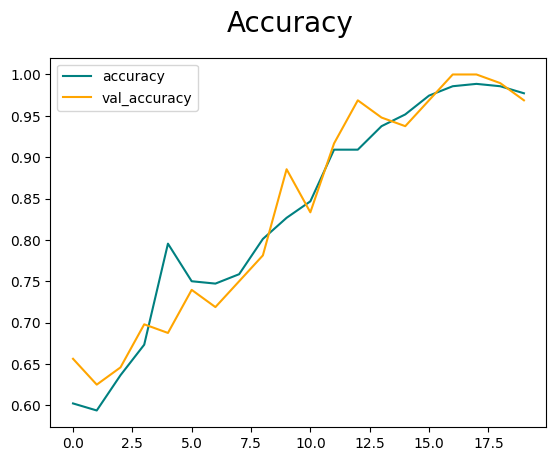

In [184]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [185]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [186]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [187]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 203ms/step


In [188]:
print(f'Precicion:{pre.result()}, Recall:{re.result()}, Accuracy:{acc.result()}')

Precicion:0.9487179517745972, Recall:1.0, Accuracy:0.976190447807312


# Test on random image

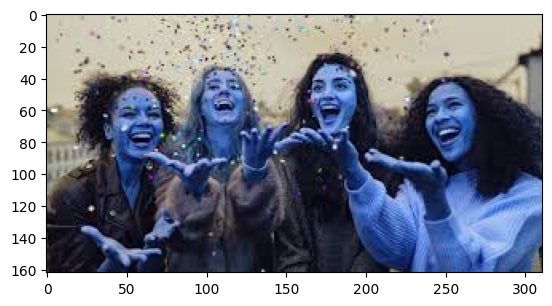

In [193]:
img = cv2.imread('happy_test.jpg')
plt.imshow(img)
plt.show()

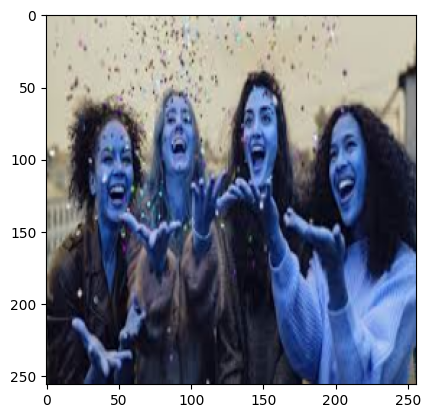

In [194]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [195]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 50ms/step


array([[0.41156214]], dtype=float32)

In [196]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# Save the model

In [197]:
from tensorflow.keras.models import load_model

In [198]:
model.save(os.path.join('model','imageclassifier.h5'))

In [200]:
new_model = load_model(os.path.join('model','imageclassifier.h5'))

In [201]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 136ms/step


array([[0.41156214]], dtype=float32)

In [202]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
